In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

In [10]:
def create_lagged_features(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

In [11]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [12]:
def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    mape = mean_absolute_percentage_error(true, pred) * 100
    return mae, mape

In [ ]:
# Load dataset
# def load_data():
#     # Simulated dataset (replace with your real data)
#     np.random.seed(42)
#     dates = pd.date_range(start="2022-01-01", periods=730)
#     # Create bursty high-fluctuation data
#     cpu_usage = []
#     current = 200

#     for _ in range(len(dates)):
#         spike = np.random.randint(-100, 100)
#         current = max(0, current + spike + np.random.normal(0, 15))
#         cpu_usage.append(current)
    
#     # cpu_usage = np.random.normal(loc=50, scale=10, size=len(dates)) + 10 * np.sin(np.linspace(0, 3 * np.pi, len(dates)))

#     df = pd.DataFrame({
#         'date': dates,
#         'namespace': ['default'] * len(dates),
#         'cpu_used': cpu_usage
#     })
#     df.set_index('date', inplace=True)
#     return df

In [14]:
df = pd.read_csv('../data/cpu_usage_simulated.csv', parse_dates=['date'], index_col='date')
df = df[df['namespace'] == 'alpha']

In [18]:
# plot_pacf(df['cpu_used'].dropna(),lags=90)
# plot_acf(df['cpu_used'].dropna(),lags=90)

MAE: 70.58, MAPE: 25.19%


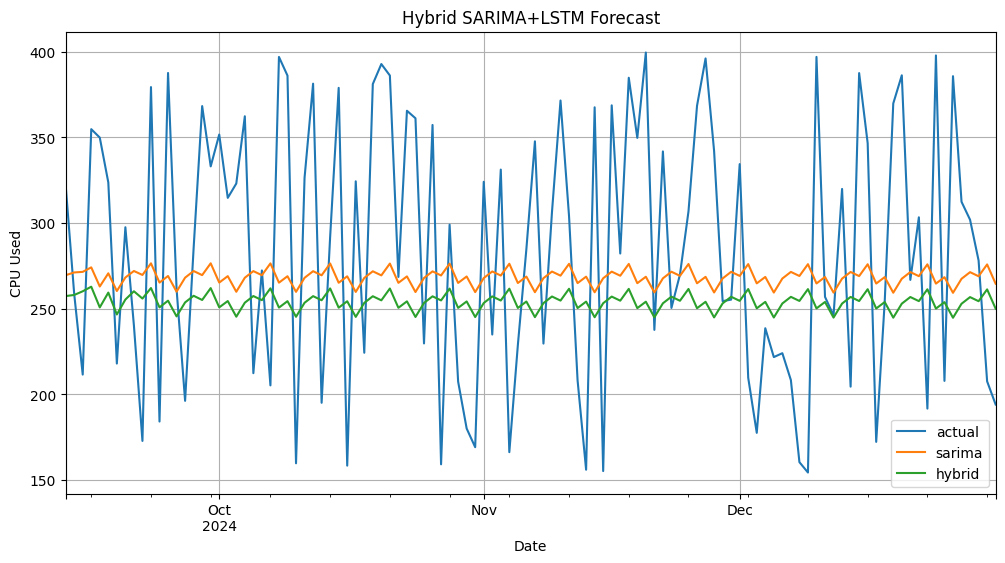

In [19]:
# Train/test split
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# SARIMA model
sarima_model = SARIMAX(train['cpu_used'], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.get_prediction(start=test.index[0], end=test.index[-1])
sarima_pred_mean = sarima_forecast.predicted_mean
residuals = train['cpu_used'] - sarima_result.fittedvalues

# LSTM on residuals
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.dropna().values.reshape(-1, 1))
n_lags = 10
X, y = create_lagged_features(residuals_scaled, n_lags)
X = X.reshape((X.shape[0], X.shape[1], 1))
lstm_model = build_lstm_model((X.shape[1], 1))
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lstm_model.fit(X, y, epochs=100, verbose=0, callbacks=[early_stop])

# Forecast residuals
last_residuals = residuals_scaled[-n_lags:].reshape(1, n_lags, 1)
lstm_forecast = []
for _ in range(len(test)):
    next_res = lstm_model.predict(last_residuals, verbose=0)
    lstm_forecast.append(next_res[0, 0])
    last_residuals = np.append(last_residuals[:, 1:, :], [[[next_res[0, 0]]]], axis=1)
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()

# Final prediction
final_forecast = sarima_pred_mean.values + lstm_forecast
mae, mape = evaluate_model(test['cpu_used'].values, final_forecast)

# Display results
print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%")
final_df = pd.DataFrame({
    'actual': test['cpu_used'].values,
    'sarima': sarima_pred_mean.values,
    'hybrid': final_forecast
}, index=test.index)

final_df.plot(figsize=(12, 6), title='Hybrid SARIMA+LSTM Forecast')
plt.ylabel('CPU Used')
plt.xlabel('Date')
plt.grid()
plt.show()


In [20]:
final_df.tail(90)

,actual,sarima,hybrid
date,,,
2024-10-03,323.069141,259.916359,245.368664
2024-10-04,362.298913,268.097493,253.548951
2024-10-05,212.417002,271.962622,257.414672
2024-10-06,272.356241,269.575665,255.026934
2024-10-07,205.302360,276.467764,261.918347
...,...,...,...
2024-12-27,312.411662,267.487892,252.933655
2024-12-28,301.934199,271.353055,256.798818
2024-12-29,278.172128,268.966057,254.411820


In [21]:
mae, mape = evaluate_model(final_df['actual'], final_df['hybrid'])
print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%")

MAE: 70.58, MAPE: 25.19%


In [10]:
final_df.reset_index().to_csv('../forecast/hybrid_forecast_cpu_usage_sarima_lstm.csv', index=False)